# Neural Cellular Automata

## Imports and hyperparameters

In [1]:
# imports
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import fastcore.all as fc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pclab.utils import def_device

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# hyperparameters
CHANNEL_N = 16
TARGET_PADDING = 16
TARGET_SIZE = 40

POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

## Loading the target image

Image of shape: (40, 40, 4) and type: uint8 with values in range: 0 to 255


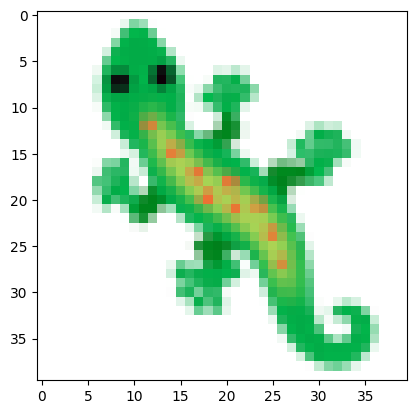

In [3]:
path = 'images/emoji_u1f98e.png'

# Open the image
img = Image.open(path).resize((TARGET_SIZE, TARGET_SIZE))

# Convert the image to numpy array
img = np.array(img)
print(f"Image of shape: {img.shape} and type: {img.dtype} with values in range: {img.min()} to {img.max()}")

# Show the image
plt.imshow(img)
plt.show()


Image of shape: (40, 40, 4) and type: float32 with values in range: 0.0 to 1.0


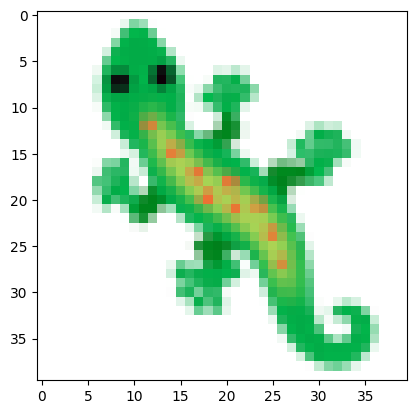

In [4]:
img = img.astype(np.float32) / 255.0
print(f"Image of shape: {img.shape} and type: {img.dtype} with values in range: {img.min()} to {img.max()}")
plt.imshow(img)
plt.show()


## Creating the Model

Defining the filters that we will apply to the image. Instead of applying 2 sobels filters and concatenate the results with the input we use and identity filter as well. 

In [5]:
# According to the paper we apply 3 filters, a horizontal sobel filter, a vertical sobel filter and an identity filter
filters = torch.stack([
    torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),      # Identity filter 
    torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),   # Vertical sobel filter
    torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T  # Horizontal sobel filter
]).to(def_device)

In [6]:
filters

tensor([[[ 0.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  0.]],

        [[-1.,  0.,  1.],
         [-2.,  0.,  2.],
         [-1.,  0.,  1.]],

        [[-1., -2., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  2.,  1.]]], device='cuda:0')

In [7]:
def perchannel_conv(x, filters):
    b, c, h, w = x.shape
    y = x.reshape(b * c, 1, h, w)
    y = F.pad(y, (1, 1, 1, 1), mode='circular')
    y = F.conv2d(y, filters[:, None])
    return y.reshape(b, -1, h, w)

Testing the result of applying the filters in the imput image

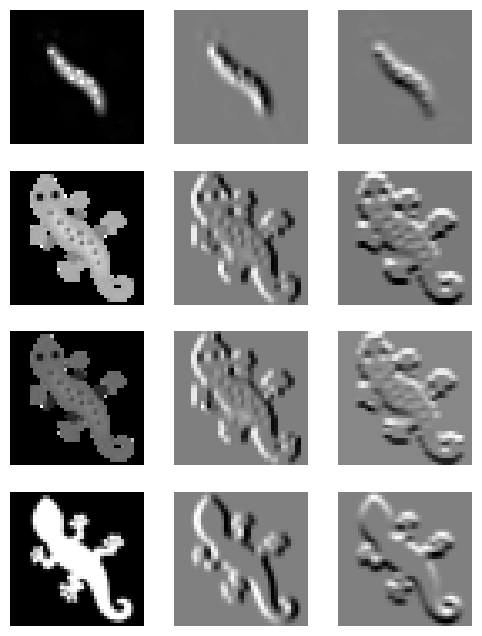

In [8]:
img_tensor = torch.tensor(img).permute(2, 0, 1)[None].to(def_device)
img_filters = perchannel_conv(img_tensor, filters)

# This will result in 3 images, one for each filter (RGBA)
# Visualize all 12 channels in a 4x3 grid
plt.figure(figsize=(6, 8))
for i in range(12):

    plt.subplot(4, 3, i + 1)
    plt.imshow(img_filters[0, i].detach().cpu(), cmap='gray')
    plt.axis('off')


In [9]:
img_filters = torch.cat([img_tensor, img_filters], dim=1)
img_filters.shape


torch.Size([1, 16, 40, 40])

We need a function that will detect the alive cells:

In [10]:
def alive(x, threshold=0.1):
    x = F.pad(x, (1, 1, 1, 1), mode='circular')
    return F.max_pool2d(x, 3, stride=1, padding=0) > threshold

And finally the CAModel is as follows:

In [11]:
class CAModel(nn.Module):

    def __init__(self, channel_n, update_rate=0.5):
        super(CAModel, self).__init__()
        self.channel_n = channel_n
        self.update_rate = update_rate
        

        self.brain = nn.Sequential(
            nn.Conv2d(channel_n * 3, 128, kernel_size=1), # pixel-wise mlp 
            nn.ReLU(),
            nn.Conv2d(128, self.channel_n, kernel_size=1, bias=False)
        )

        # this network is used to calculate the change of the features, so initially, we dont want to suggest any changes
        # thus we set the output weights to zero
        with torch.no_grad():
            self.brain[-1].weight.zero_()


    def step(self, x, update_rate=None):
                
        # -- Perception -- (apply the filters to the input)
        y = perchannel_conv(x, filters)
        
        # -- Update Rule -- (pass the input through the brain)
        y = self.brain(y)

        # -- Stochastic cell update --
        B, C, H, W = y.shape
        update_rate = update_rate or self.update_rate # if update_rate is not given, use the default value
        update_mask = (torch.rand(B, 1, H, W).to(def_device) + update_rate).floor() 
        x = x + y * update_mask # update only a fraction of the cells

        # -- Alive masking --
        alive_mask = alive(x[:, 3:4, :, :], threshold=0.1) # we use 3:4 to keep the dimension
        x = x * alive_mask

        return x

    def forward(self, x, steps=1, update_rate=None):
        for i in range(steps):
            x = self.step(x, update_rate=update_rate)
        return x
    

## Experiment 1: Learning to Grow

Create a grid with zeros, except a single cell in the center, which will have all channels, except RGB, set to 1. 

*We set the RGB channels of the seed to zero because we want it to be visible on the white background.*

In [12]:
seed = torch.zeros(1, 16, TARGET_SIZE, TARGET_SIZE).to(def_device)
seed[:, 3:, TARGET_SIZE//2, TARGET_SIZE//2] = 1.0

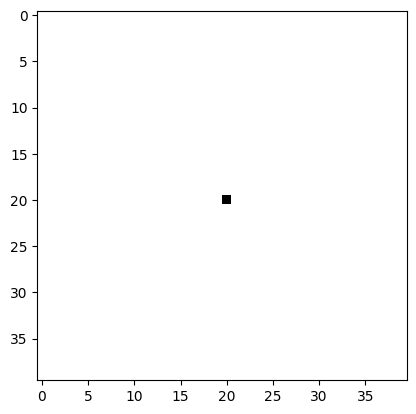

In [13]:
plt.imshow(seed[0, :4].detach().cpu().permute(1, 2, 0))
plt.show()

We also sample a random number of CA steps from the [64, 96] range. 

*This should be a sufficient number of steps to grow the pattern of the size we work with (40x40), even considering the stochastic nature of our update rule.*

In [14]:
from tqdm import tqdm
n_epochs = 8000
batch_size = 8

ca = CAModel(CHANNEL_N).to(def_device)


lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
optimizer = torch.optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

input = seed.repeat(batch_size, 1, 1, 1)
target = img_tensor.repeat(batch_size, 1, 1, 1)

for i in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    steps = torch.randint(64, 96, (1,)).item()
    res = ca(input, steps=steps)

    loss = F.mse_loss(res[:, :4], target) # we only care about the RGBA channels
    if i%100 == 0:
        print(f"Epoch: {i} Loss: {loss.item()}")
    loss.backward()
    optimizer.step()
    scheduler.step()


  0%|          | 1/8000 [00:00<30:25,  4.38it/s]

Epoch: 0 Loss: 0.11318174749612808


  1%|▏         | 102/8000 [00:09<11:44, 11.21it/s]

Epoch: 100 Loss: 0.03525052219629288


  3%|▎         | 202/8000 [00:18<11:13, 11.57it/s]

Epoch: 200 Loss: 0.028989974409341812


  4%|▍         | 302/8000 [00:27<11:43, 10.95it/s]

Epoch: 300 Loss: 0.017590848729014397


  5%|▌         | 402/8000 [00:36<11:25, 11.08it/s]

Epoch: 400 Loss: 0.018316132947802544


  6%|▋         | 502/8000 [00:45<11:09, 11.21it/s]

Epoch: 500 Loss: 0.0121740298345685


  8%|▊         | 602/8000 [00:54<11:17, 10.92it/s]

Epoch: 600 Loss: 0.01563141867518425


  9%|▉         | 702/8000 [01:03<10:14, 11.88it/s]

Epoch: 700 Loss: 0.010205253027379513


 10%|█         | 802/8000 [01:12<10:27, 11.48it/s]

Epoch: 800 Loss: 0.0095592699944973


 11%|█▏        | 902/8000 [01:21<10:36, 11.15it/s]

Epoch: 900 Loss: 0.007059864234179258


 13%|█▎        | 1002/8000 [01:30<10:51, 10.74it/s]

Epoch: 1000 Loss: 0.010450943373143673


 14%|█▍        | 1102/8000 [01:39<10:51, 10.59it/s]

Epoch: 1100 Loss: 0.012004474177956581


 15%|█▌        | 1202/8000 [01:47<10:25, 10.87it/s]

Epoch: 1200 Loss: 0.006424465216696262


 16%|█▋        | 1302/8000 [01:56<10:08, 11.01it/s]

Epoch: 1300 Loss: 0.005228639580309391


 18%|█▊        | 1402/8000 [02:05<10:18, 10.67it/s]

Epoch: 1400 Loss: 0.005001758225262165


 19%|█▉        | 1502/8000 [02:14<09:40, 11.19it/s]

Epoch: 1500 Loss: 0.005890006199479103


 20%|██        | 1602/8000 [02:23<09:45, 10.92it/s]

Epoch: 1600 Loss: 0.007210707291960716


 21%|██▏       | 1702/8000 [02:32<09:38, 10.89it/s]

Epoch: 1700 Loss: 0.0040181172080338


 23%|██▎       | 1802/8000 [02:41<09:34, 10.78it/s]

Epoch: 1800 Loss: 0.004480003844946623


 24%|██▍       | 1902/8000 [02:50<09:23, 10.82it/s]

Epoch: 1900 Loss: 0.005969875957816839


 25%|██▌       | 2002/8000 [02:59<08:55, 11.21it/s]

Epoch: 2000 Loss: 0.004207409918308258


 26%|██▋       | 2102/8000 [03:08<08:37, 11.40it/s]

Epoch: 2100 Loss: 0.0034953223075717688


 28%|██▊       | 2202/8000 [03:17<08:19, 11.60it/s]

Epoch: 2200 Loss: 0.0030496695544570684


 29%|██▉       | 2302/8000 [03:26<08:31, 11.15it/s]

Epoch: 2300 Loss: 0.0031456942670047283


 30%|███       | 2402/8000 [03:35<07:59, 11.68it/s]

Epoch: 2400 Loss: 0.003532454837113619


 31%|███▏      | 2502/8000 [03:43<08:41, 10.55it/s]

Epoch: 2500 Loss: 0.002360469428822398


 33%|███▎      | 2602/8000 [03:52<08:11, 10.99it/s]

Epoch: 2600 Loss: 0.0024858606047928333


 34%|███▍      | 2702/8000 [04:01<08:01, 11.00it/s]

Epoch: 2700 Loss: 0.0025391429662704468


 35%|███▌      | 2802/8000 [04:10<07:47, 11.11it/s]

Epoch: 2800 Loss: 0.002966936444863677


 36%|███▋      | 2902/8000 [04:19<07:43, 11.00it/s]

Epoch: 2900 Loss: 0.004155296366661787


 38%|███▊      | 3002/8000 [04:28<07:37, 10.92it/s]

Epoch: 3000 Loss: 0.0023789559490978718


 39%|███▉      | 3102/8000 [04:37<07:10, 11.38it/s]

Epoch: 3100 Loss: 0.0024895521346479654


 40%|████      | 3202/8000 [04:46<06:40, 11.98it/s]

Epoch: 3200 Loss: 0.002345004817470908


 41%|████▏     | 3302/8000 [04:54<07:20, 10.65it/s]

Epoch: 3300 Loss: 0.0016551471780985594


 43%|████▎     | 3402/8000 [05:03<07:02, 10.89it/s]

Epoch: 3400 Loss: 0.0016328127821907401


 44%|████▍     | 3502/8000 [05:12<06:30, 11.52it/s]

Epoch: 3500 Loss: 0.003453741781413555


 45%|████▌     | 3602/8000 [05:20<06:19, 11.58it/s]

Epoch: 3600 Loss: 0.002150495769456029


 46%|████▋     | 3702/8000 [05:29<06:13, 11.51it/s]

Epoch: 3700 Loss: 0.002455251757055521


 48%|████▊     | 3802/8000 [05:38<06:16, 11.16it/s]

Epoch: 3800 Loss: 0.0012300052912905812


 49%|████▉     | 3902/8000 [05:47<06:04, 11.23it/s]

Epoch: 3900 Loss: 0.001475877477787435


 50%|█████     | 4002/8000 [05:56<05:40, 11.74it/s]

Epoch: 4000 Loss: 0.0022592677269130945


 51%|█████▏    | 4102/8000 [06:05<05:39, 11.47it/s]

Epoch: 4100 Loss: 0.0029608169570565224


 53%|█████▎    | 4202/8000 [06:14<05:26, 11.64it/s]

Epoch: 4200 Loss: 0.0016651895130053163


 54%|█████▍    | 4302/8000 [06:23<05:43, 10.77it/s]

Epoch: 4300 Loss: 0.0014201056910678744


 55%|█████▌    | 4402/8000 [06:32<05:13, 11.47it/s]

Epoch: 4400 Loss: 0.0013641935074701905


 56%|█████▋    | 4502/8000 [06:41<05:09, 11.30it/s]

Epoch: 4500 Loss: 0.00124855968169868


 58%|█████▊    | 4602/8000 [06:49<05:03, 11.21it/s]

Epoch: 4600 Loss: 0.0019866167567670345


 59%|█████▉    | 4702/8000 [06:58<04:54, 11.19it/s]

Epoch: 4700 Loss: 0.001105772564187646


 60%|██████    | 4802/8000 [07:07<04:59, 10.68it/s]

Epoch: 4800 Loss: 0.0014473343035206199


 61%|██████▏   | 4902/8000 [07:16<04:33, 11.31it/s]

Epoch: 4900 Loss: 0.0009996014414355159


 63%|██████▎   | 5002/8000 [07:25<04:23, 11.37it/s]

Epoch: 5000 Loss: 0.000945043982937932


 64%|██████▍   | 5102/8000 [07:34<04:02, 11.94it/s]

Epoch: 5100 Loss: 0.002352194394916296


 65%|██████▌   | 5202/8000 [07:43<04:12, 11.07it/s]

Epoch: 5200 Loss: 0.001512814313173294


 66%|██████▋   | 5302/8000 [07:52<04:06, 10.92it/s]

Epoch: 5300 Loss: 0.0021147828083485365


 68%|██████▊   | 5402/8000 [08:01<03:57, 10.95it/s]

Epoch: 5400 Loss: 0.0007970326696522534


 69%|██████▉   | 5502/8000 [08:09<03:50, 10.84it/s]

Epoch: 5500 Loss: 0.0014948801835998893


 70%|███████   | 5602/8000 [08:18<03:50, 10.39it/s]

Epoch: 5600 Loss: 0.0007234566728584468


 71%|███████▏  | 5702/8000 [08:27<03:13, 11.88it/s]

Epoch: 5700 Loss: 0.0009298463119193912


 73%|███████▎  | 5802/8000 [08:36<03:22, 10.86it/s]

Epoch: 5800 Loss: 0.0007856481825001538


 74%|███████▍  | 5902/8000 [08:45<03:05, 11.31it/s]

Epoch: 5900 Loss: 0.000529628072399646


 75%|███████▌  | 6002/8000 [08:54<03:06, 10.69it/s]

Epoch: 6000 Loss: 0.000770733633544296


 76%|███████▋  | 6102/8000 [09:03<02:38, 11.94it/s]

Epoch: 6100 Loss: 0.0014301433693617582


 78%|███████▊  | 6202/8000 [09:12<02:43, 10.97it/s]

Epoch: 6200 Loss: 0.0005659727612510324


 79%|███████▉  | 6302/8000 [09:21<02:33, 11.03it/s]

Epoch: 6300 Loss: 0.0006726844585500658


 80%|████████  | 6402/8000 [09:30<02:25, 11.01it/s]

Epoch: 6400 Loss: 0.00045380674418993294


 81%|████████▏ | 6502/8000 [09:39<02:09, 11.53it/s]

Epoch: 6500 Loss: 0.0013937375042587519


 83%|████████▎ | 6602/8000 [09:48<02:01, 11.54it/s]

Epoch: 6600 Loss: 0.0010113328462466598


 84%|████████▍ | 6702/8000 [09:56<01:51, 11.63it/s]

Epoch: 6700 Loss: 0.0006288090953603387


 85%|████████▌ | 6802/8000 [10:05<01:50, 10.87it/s]

Epoch: 6800 Loss: 0.0004493745800573379


 86%|████████▋ | 6902/8000 [10:14<01:41, 10.87it/s]

Epoch: 6900 Loss: 0.000464659184217453


 88%|████████▊ | 7002/8000 [10:23<01:25, 11.67it/s]

Epoch: 7000 Loss: 0.0007287254557013512


 89%|████████▉ | 7102/8000 [10:32<01:13, 12.25it/s]

Epoch: 7100 Loss: 0.0010355095146223903


 90%|█████████ | 7202/8000 [10:40<01:09, 11.54it/s]

Epoch: 7200 Loss: 0.0004805964417755604


 91%|█████████▏| 7302/8000 [10:49<01:02, 11.18it/s]

Epoch: 7300 Loss: 0.0010960620129480958


 93%|█████████▎| 7402/8000 [10:58<00:55, 10.81it/s]

Epoch: 7400 Loss: 0.0005736529128625989


 94%|█████████▍| 7502/8000 [11:07<00:46, 10.69it/s]

Epoch: 7500 Loss: 0.0003403130976948887


 95%|█████████▌| 7602/8000 [11:16<00:33, 11.76it/s]

Epoch: 7600 Loss: 0.000973149377387017


 96%|█████████▋| 7702/8000 [11:25<00:27, 10.70it/s]

Epoch: 7700 Loss: 0.0006168862455524504


 98%|█████████▊| 7802/8000 [11:34<00:17, 11.54it/s]

Epoch: 7800 Loss: 0.0007852566777728498


 99%|█████████▉| 7902/8000 [11:43<00:08, 11.44it/s]

Epoch: 7900 Loss: 0.0008073857170529664


100%|██████████| 8000/8000 [11:52<00:00, 11.23it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


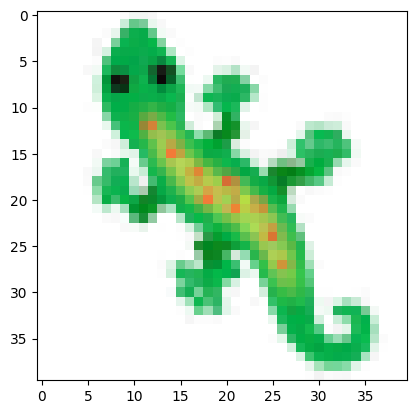

In [15]:
plt.imshow(res[0, :4].detach().cpu().permute(1, 2, 0))
plt.show()

### Create an animation to show the generation process

In [44]:
@fc.patch
def grow_animation(self: CAModel, seed, steps, update_rate=None):
    x = seed.clone()
    images = [torch.clamp(x[0, :4].detach().cpu().permute(1, 2, 0), 0, 1)]
    for _ in range(steps):
        x = self.step(x, update_rate=update_rate)
        images.append(torch.clamp(x[0, :4].detach().cpu().permute(1, 2, 0), 0, 1))
    return images

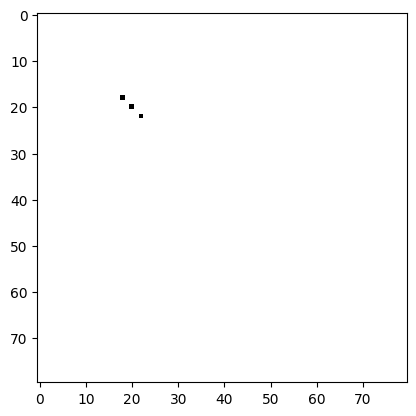

In [55]:
s = torch.zeros(1, 16, 80, 80).to(def_device)
s[:, 3:, [18, 20, 22], [18, 20, 22]] = 1
plt.imshow(s.detach().cpu().squeeze().permute(1, 2, 0)[..., :4])
plt.show()

In [56]:
images = ca.grow_animation(s, 200)

In [57]:
# create a function to display the animation
def display_animation(images):
    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    ims = [[plt.imshow(image, animated=True)] for image in images]
    # display animation in jupyter notebook
    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    # display HTML
    return HTML(ani.to_jshtml())    

In [58]:
display_animation(images)

In [61]:
path = "/home/ioannis/Desktop/programming/phd/ExpPointMAE_continue/pclab/nbs/experiments/automata_checkpoints/ca_grow.pt"
torch.save({
    'model_state_dict': ca.state_dict()
}, path)